In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
import numpy as np

In [2]:
df = pd.read_csv('dataset.csv')

In [3]:
df_filtered = df[['normalized_salary', 'formatted_work_type']].dropna().copy()

In [4]:
# Encode categorical columns
column_transformer = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(sparse_output=False), ['formatted_work_type'])  # Replace with your categorical column names
    ],
    remainder='passthrough'  # Keep other columns as is
)

# Transform the data
df_encoded = column_transformer.fit_transform(df_filtered)

# Convert to DataFrame if needed
df_encoded = pd.DataFrame(df_encoded)

# Ensure all features are numerical
df_filtered.reset_index(drop=True, inplace=True)
df_encoded.reset_index(drop=True, inplace=True)

# Combine encoded features with other numerical columns
df_combined = pd.concat([df_encoded, df_filtered[['normalized_salary']]], axis=1) 

In [5]:
kmeans = KMeans(n_clusters=3, random_state=42)
df_combined['Cluster_KMeans'] = kmeans.fit_predict(df_encoded)

In [6]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
df_combined['Cluster_DBSCAN'] = dbscan.fit_predict(df_encoded)
df_combined['Outlier_Flag'] = (df_combined['Cluster_DBSCAN'] == -1).astype(int)

In [7]:
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(df_encoded)
df_filtered['Cluster_GMM'] = gmm.predict(df_encoded)
df_filtered['Cluster_Prob_GMM'] = gmm.predict_proba(df_encoded).max(axis=1)

In [8]:
print(df_filtered.head())


   normalized_salary formatted_work_type  Cluster_GMM  Cluster_Prob_GMM
0            38480.0           Full-time            1               1.0
1            55000.0           Full-time            1               1.0
2           157500.0           Full-time            1               1.0
3            35360.0          Internship            0               1.0
4           180000.0            Contract            0               1.0


In [28]:
# 1. Kết hợp các cột mới vào dữ liệu gốc
df_augmented = df.copy()  # Tạo bản sao của df gốc

# 2. Thêm các cột từ kết quả phân cụm vào df gốc
df_augmented['Cluster_KMeans'] = df_combined['Cluster_KMeans']
df_augmented['Cluster_DBSCAN'] = df_combined['Cluster_DBSCAN']
df_augmented['Outlier_Flag'] = df_combined['Outlier_Flag']
df_augmented['Cluster_GMM'] = df_filtered['Cluster_GMM']
df_augmented['Cluster_Prob_GMM'] = df_filtered['Cluster_Prob_GMM']

# 3. Kiểm tra lại dữ liệu đã được kết hợp
print(df_augmented.head(10))

      job_id                                  company_name  \
0     921716                         Corcoran Sawyer Smith   
1   10998357                        The National Exemplar    
2   23221523                        Abrams Fensterman, LLP   
3   91700727                     Downtown Raleigh Alliance   
4  103254301                                    Raw Cereal   
5  266566927                            Revesco Properties   
6  266825034                            Recruitment Design   
7  280496925                   Washington State University   
8  445337908                           Food Bank of Alaska   
9  606178500  Jung & Vassar PC Attorneys At Law A Law Corp   

                                               title  max_salary pay_period  \
0                              Marketing Coordinator        20.0     HOURLY   
1                        Assitant Restaurant Manager     65000.0     YEARLY   
2  Senior Elder Law / Trusts and Estates Associat...    175000.0     YEARLY   
3

In [9]:
# 1. Kết hợp các cột mới vào dữ liệu gốc
df_augmented = df.copy()  # Tạo bản sao của df gốc

# 2. Thêm các cột từ kết quả phân cụm vào df gốc
df_augmented['Cluster_KMeans'] = df_combined['Cluster_KMeans']
df_augmented['Cluster_DBSCAN'] = df_combined['Cluster_DBSCAN']
df_augmented['Outlier_Flag'] = df_combined['Outlier_Flag']
df_augmented['Cluster_GMM'] = df_filtered['Cluster_GMM']
df_augmented['Cluster_Prob_GMM'] = df_filtered['Cluster_Prob_GMM']

# 3. Kiểm tra lại dữ liệu đã được kết hợp
print(df_augmented.head(10))

# --- BỔ SUNG: GIẢM CHIỀU VỚI PCA (CHƯƠNG 8) ---
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# Chỉ lấy các cột số (numeric) và các cột cluster info
numeric_cols = df_augmented.select_dtypes(include=[np.number]).columns.tolist()
cluster_cols = ['Cluster_KMeans', 'Cluster_DBSCAN', 'Outlier_Flag', 'Cluster_GMM', 'Cluster_Prob_GMM']
feature_cols = list(set(numeric_cols) | set(cluster_cols))

X = df_augmented[feature_cols].fillna(0)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Giảm chiều với PCA (giữ lại 95% phương sai)
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Shape trước PCA:", X_scaled.shape)
print("Shape sau PCA:", X_pca.shape)
print("Tổng phương sai giữ lại:", pca.explained_variance_ratio_.sum())
print("Một vector đầu ra sau PCA:", X_pca[0])

      job_id                                  company_name  \
0     921716                         Corcoran Sawyer Smith   
1   10998357                        The National Exemplar    
2   23221523                        Abrams Fensterman, LLP   
3   91700727                     Downtown Raleigh Alliance   
4  103254301                                    Raw Cereal   
5  266566927                            Revesco Properties   
6  266825034                            Recruitment Design   
7  280496925                   Washington State University   
8  445337908                           Food Bank of Alaska   
9  606178500  Jung & Vassar PC Attorneys At Law A Law Corp   

                                               title  max_salary pay_period  \
0                              Marketing Coordinator        20.0     HOURLY   
1                        Assitant Restaurant Manager     65000.0     YEARLY   
2  Senior Elder Law / Trusts and Estates Associat...    175000.0     YEARLY   
3

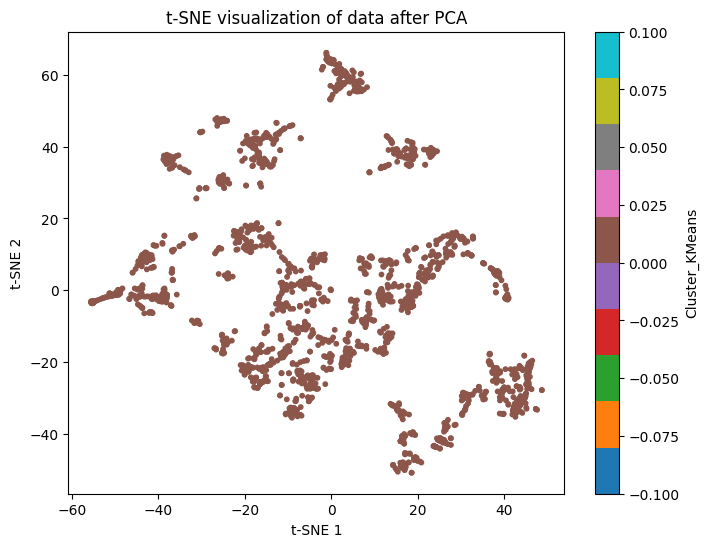

In [10]:
# Sau khi đã có X_pca (dữ liệu đã giảm chiều bằng PCA)

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Chỉ lấy một phần dữ liệu để t-SNE chạy nhanh (ví dụ 2000 điểm)
n_samples = 2000
X_vis = X_pca[:n_samples]
y_vis = None  # Nếu bạn có nhãn, hãy thay bằng y[:n_samples]

# Áp dụng t-SNE để giảm còn 2 chiều cho trực quan hóa
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_vis)

# Nếu bạn có nhãn (ví dụ: df_augmented['Cluster_KMeans'] hoặc Outlier_Flag)
# thì có thể truyền vào để tô màu theo cụm hoặc outlier
labels = df_augmented['Cluster_KMeans'].values[:n_samples]  # hoặc Outlier_Flag, Cluster_GMM, v.v.

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_tsne[:,0], X_tsne[:,1], c=labels, cmap='tab10', s=10)
plt.title("t-SNE visualization of data after PCA")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(scatter, label="Cluster_KMeans")
plt.show()

In [12]:
# step 5: supervised learning (train-test split, scale, train, predict, evaluate)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

X = df_augmented[['Cluster_KMeans', 'Cluster_DBSCAN', 'Outlier_Flag', 'Cluster_GMM', 'Cluster_Prob_GMM']]
y = df_augmented['Cluster_KMeans']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_scaled, y_train)

# Make predictions
y_pred = clf.predict(X_test_scaled)
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# Print the first few rows of the augmented DataFrame

Accuracy: 0.9998295841854125
Precision: 0.9997443762781186
Recall: 0.9998295841854125
F1 Score: 0.9997727789138833
Confusion Matrix:
 [[5866    0    0]
 [   0    1    0]
 [   0    1    0]]


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
